In [27]:
import warnings 
warnings.filterwarnings("ignore" , "Wswiglal-redir-studio")

import h5py
import scipy
import pycbc
import numpy as np
from pycbc import noise 
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from pycbc.waveform import get_fd_waveform , get_waveform_filter_length_in_time as chirplen 
from pycbc.waveform.generator import (FDomainDetFrameGenerator , FDomainCBCGenerator) 
from pycbc.psd import aLIGOZeroDetHighPower , AdVDesignSensitivityP1200087  
from pycbc.noise.gaussian import frequency_noise_from_psd 
from pycbc.filter.matchedfilter import matched_filter 
import lal
from HelperFn import *  

In [28]:
## The parameters of the binary...

m1 , m2 , s1z , s2z = 9 , 8 , 0.3 , 0.6
distance = 320
fsamp , flow , fhigh = 4096 , 15 , 2048
alpha = np.pi                      # Right Ascension 
delta = -np.pi/6                   # Declination
iota = np.pi / 4                   # Inclination angle
phic = np.pi / 3                   # Coalescence phase
psi = 0                            # Polarization Angle
tStart = 1367469555                # GPS time for the epoch, which corresponds to 7May2023-04:38:57UTC.
dt = 1/fsamp                       # Time resolution 
ifos= ['L1' , 'H1' , 'V1']         # Detectors 
mode_array = [[2, 2]]


ifo_set = [('H1', 'L1'), ('H1', 'V1'), ('L1', 'V1')]
Timedelays = {('H1', 'L1'): 0.0100, ('H1', 'V1'): 0.0273, ('L1', 'V1'): 0.0265}

# -- Setting random seed for generating noise 
np.random.seed(seed = 435)

In [29]:
signalDuration, delta_f, Nt, Nf = calculate_signal_duration("IMRPhenomD", m1, m2, s1z, s2z, flow, fsamp)

print(f'Signal Duration: {signalDuration} Seconds')

tTrigger = tStart + signalDuration

#-- Dictionary of parameters that remain fixed during signal generation
frozenParams = {
    'approximant': "IMRPhenomD",
    'mass1': m1,
    'mass2': m2,
    'spin1z': s1z,
    'spin2z': s2z,
    'delta_f': delta_f,
    'f_lower': flow,
    'f_final': fhigh,                     
    'inclination': iota,
    'distance': distance,                  
    'mode_array': mode_array,
    'coa_phase': phic
}

#-- Generating Signal in Frequency Domain
Signal_L1V1H1= Signal_Generation(m1, m2, s1z, s2z, distance, alpha, delta, signalDuration, frozenParams, tStart, psi , Nf)

Signal Duration: 19.33236611901031 Seconds


In [30]:
# -- Generating psd values for different detectors
psd_V1 = AdVDesignSensitivityP1200087(Nf , delta_f = delta_f , low_freq_cutoff = flow)
psd_AdvLIGO = aLIGOZeroDetHighPower(Nf , delta_f = delta_f , low_freq_cutoff = flow)
psd = {'L1' : psd_AdvLIGO , 'H1' : psd_AdvLIGO , 'V1' :psd_V1}

In [31]:
# -- Adding Noise to the Signal
data_fd, signal_L1V1H1_fd = Noisy_data(ifos, Signal_L1V1H1 , psd)


# -- Whitening the Data
whitened_signal = whitened(ifos, signal_L1V1H1_fd, psd, dt)
whitened_data = whitened(ifos, data_fd, psd, dt)

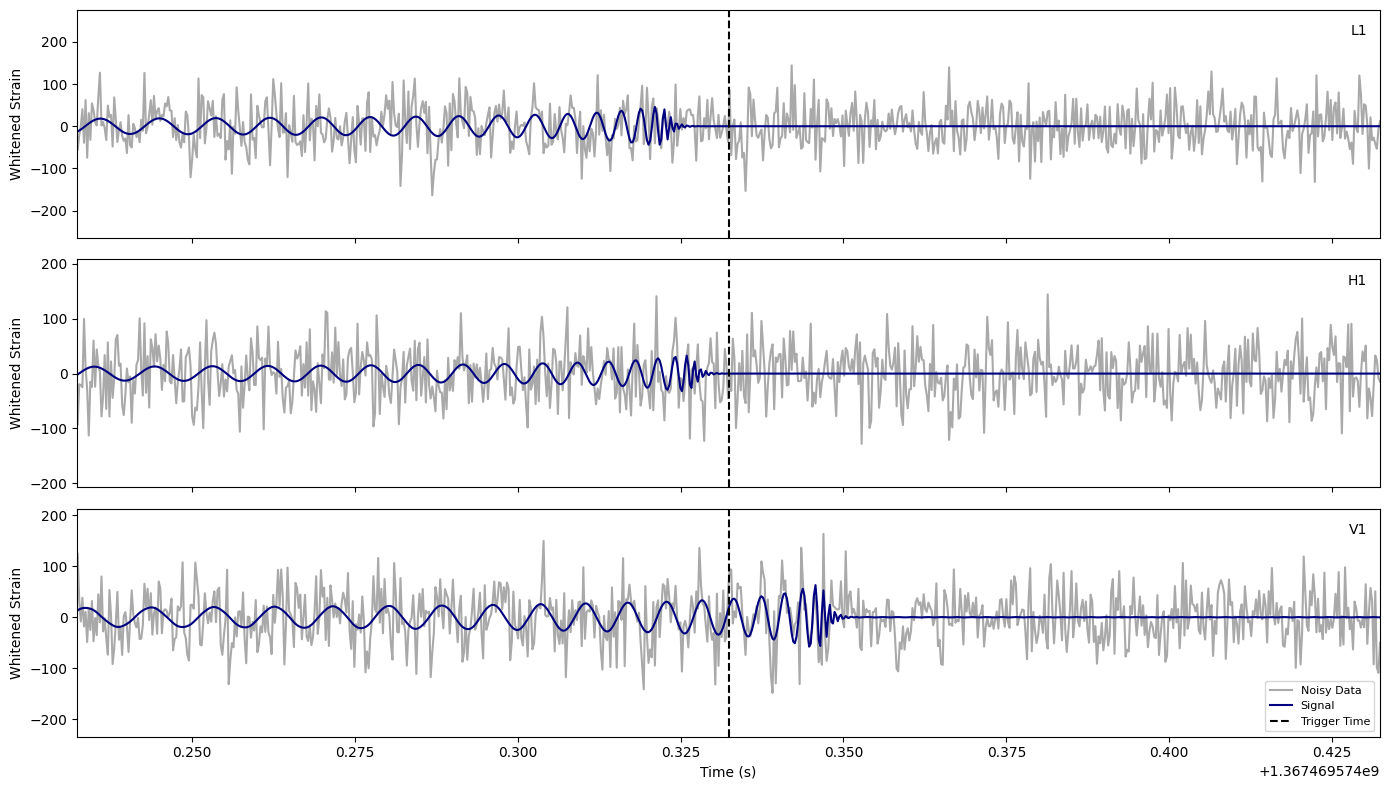

In [32]:
# -- Plotting the Whitened data
plot_whitened_data(whitened_data, whitened_signal, tStart, tTrigger, ifos , figsize = (14,8) )

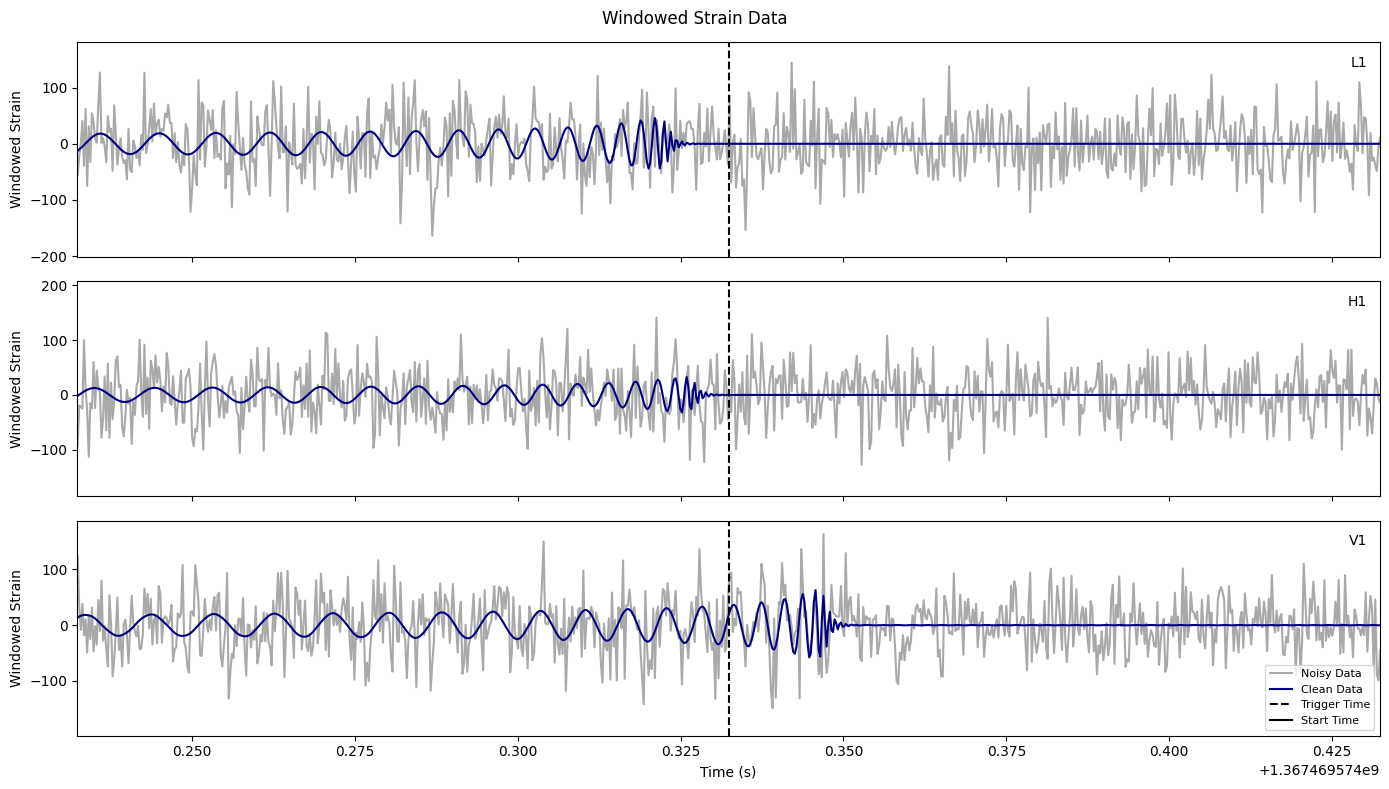

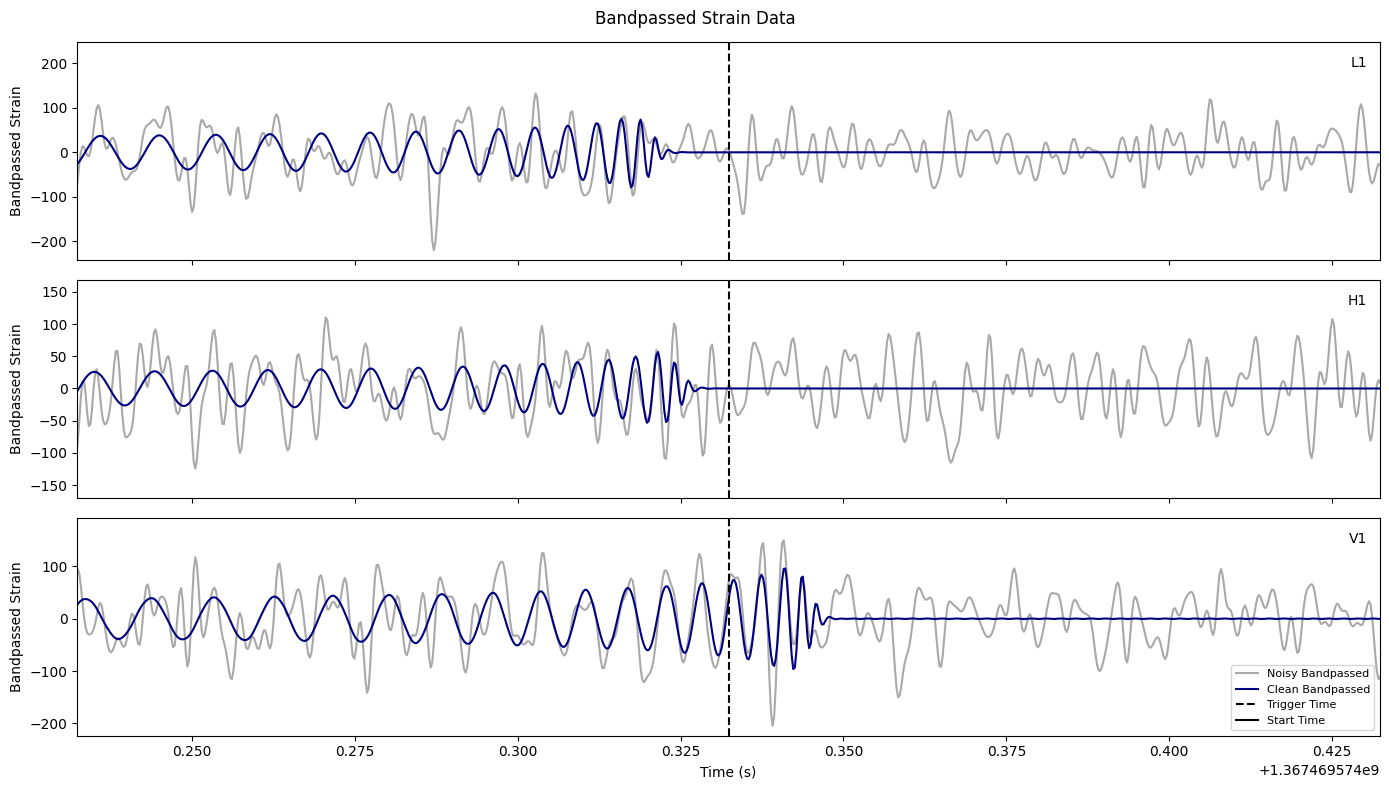

In [33]:
# -- Clipping the data (4 Seconds) around the merger 
time_around_merger, clipped_data_around_event = clip_signal_around_merger(ifos, whitened_data, tTrigger, pre_merger_time=3.5, post_merger_time=0.5)
time_around_merger, clipped_data_around_event_signal = clip_signal_around_merger(ifos, whitened_signal, tTrigger, pre_merger_time=3.5, post_merger_time=0.5)

# -- Windowing the clipped data
windowed_data_noisy = apply_tukey_window(ifos, clipped_data_around_event, alpha=1./4)
windowed_signal = apply_tukey_window(ifos, clipped_data_around_event_signal,  alpha=1./4)

# -- Bandpass the windowed data in particular frequency band 
fband = [10 , 500]
bandpassed_data_noisy = bandpass_filter(windowed_data_noisy, fband, ifos)
bandpassed_signal = bandpass_filter(windowed_signal, fband,ifos)


# -- Plotting windowed data and bandpassed data
plot_windowed_and_bandpassed(windowed_signal, windowed_data_noisy, time_around_merger, tStart, tTrigger, ifos , fband ,  figsize = (14,8))

In [34]:
time = time_around_merger
t_min = -3
t_max = 0.05
Time_lag = plot_cross_correlation(bandpassed_signal, bandpassed_data_noisy, ifo_set, Timedelays, time, t_min, t_max , tTrigger , figsize=(14,4))

In [35]:
Fbands = ( (10 , 100) , (10 , 200 ), (10 , 300) , (10 , 400) , (10 , 500), (10 , 700))

SNR = {}
Time_lag = {}
for fband in Fbands:

    bandpassed_data_noisy = bandpass_filter(windowed_data_noisy, fband, ifos)
    bandpassed_signal = bandpass_filter(windowed_signal, fband,ifos)
    SNR[fband] = matchfiltering(frozenParams , psd , data_fd , fband ,  ifos , Nf)
    Time_lag[fband] = get_cross_correlation(bandpassed_signal, bandpassed_data_noisy, ifo_set, Timedelays, time, t_min, t_max , tTrigger, fs = 4096)


In [36]:
fband_td_ts = {}
for i in Fbands:
    time_lag_in_band = Time_lag[i]
    Clean_time_lag = time_lag_in_band['Clean']
    Noisy_time_lag = time_lag_in_band['Noisy']
    de_td_ts = {}
    fband_td_ts[i] = de_td_ts
    for ifo in ifo_set:
        de_td_ts[ifo] = Noisy_time_lag[ifo]/Clean_time_lag[ifo]

In [37]:
A , B , C = [] , [] , []
for fband in Fbands:
    SNR[fband]
    A.append(SNR[fband]['L1'])
    B.append(SNR[fband]['V1'])
    C.append(SNR[fband]['H1'])

In [38]:
X , Y , Z = [] ,[] , []
for key in fband_td_ts.keys():
    key_set = fband_td_ts[key]
    X.append(key_set[('H1', 'L1')])
    Y.append(key_set[('H1', 'V1')])
    Z.append(key_set[('L1', 'V1')])

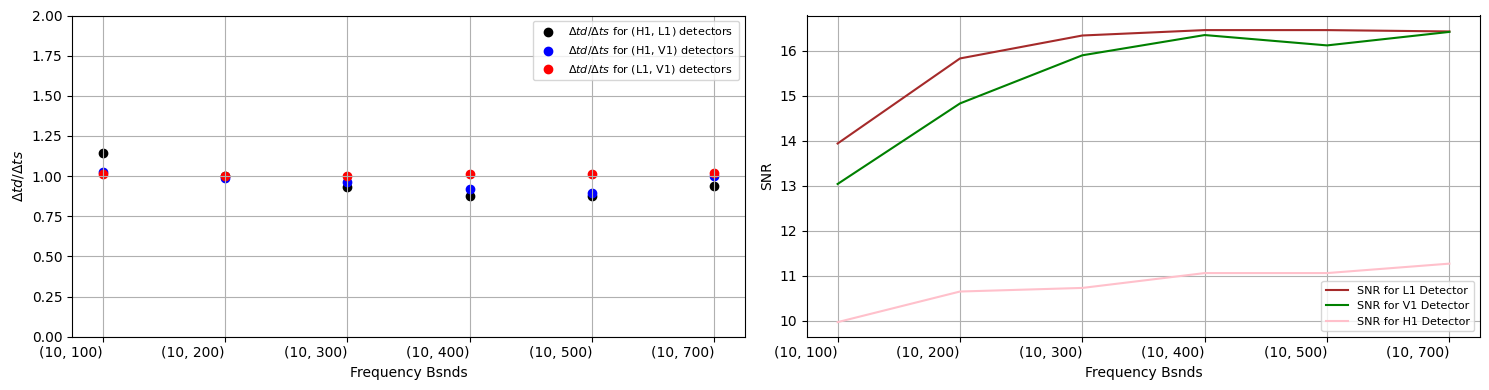

In [39]:
plt.figure(figsize = (15 ,4))

plt.subplot(1 ,2 ,1)
plt.scatter(np.arange(0, len(X)), X, c='black', label='$\\Delta td / \\Delta ts$ for (H1, L1) detectors')
plt.scatter(np.arange(0, len(Y)), Y, c='blue', label='$\\Delta td / \\Delta ts$ for (H1, V1) detectors')
plt.scatter(np.arange(0, len(Z)), Z, c='red', label='$\\Delta td / \\Delta ts$ for (L1, V1) detectors')

plt.xlabel('Frequency Bsnds')
plt.ylabel('$\\Delta td / \\Delta ts$')
plt.legend(fontsize = 8)
plt.ylim(0 , 2)
plt.xticks(ticks= np.arange(0, len(X)), labels=Fbands, ha='right')
plt.tight_layout()
plt.grid(True)


plt.subplot(1 ,2 ,2)

plt.plot(np.arange(0, len(A)) , A , c = 'brown'  , label = 'SNR for L1 Detector')
plt.plot(np.arange(0, len(A)) , B , c = 'green'  , label = 'SNR for V1 Detector')
plt.plot(np.arange(0, len(A)) , C , c = 'pink'  , label = 'SNR for H1 Detector')

plt.xlabel('Frequency Bsnds')
plt.ylabel('SNR')
plt.legend(fontsize = 8)
plt.xticks(ticks= np.arange(0, len(X)), labels=Fbands, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()
